In [1]:
import numpy as np
import tifffile
import svmbir
from scipy import ndimage
import matplotlib.pyplot as plt
import h5py

In [2]:
# function to apply in-plane rotation to projections
def rotation_matrix(h, w, angle):
    m1 = np.array([[1.0, 0.0, w/2], [0.0, 1.0, h/2], [0.0, 0.0, 1.0]])
    m2 = np.array([[np.cos(angle), np.sin(angle), 0.0], 
                   [np.sin(angle), -np.cos(angle), 0.0],
                   [0.0, 0.0, 1.0]])
    m3 = np.array([[1.0, 0.0, -w/2], [0.0, 1.0, -h/2], [0.0, 0.0, 1.0]])
    
    return m1 @ m2 @ m3

def rotate_proj_in_plane(projections, angles):
    n_proj, h, w = projections.shape
    rotated_projections = projections.copy()
    if np.size(angles) == 1:
        # apply same in-plane rotation to all projections
        rot_mat = rotation_matrix(h, w, angles)
        for n in range(n_proj):
            rotated_projections[n] = ndimage.affine_transform(rotated_projections[n], rot_mat)
    else:
        assert(np.size(angles) == n_proj)
        for n in range(n_proj):
            rot_mat = rotation_matrix(h, w, angles[n])
            rotated_projections[n] = ndimage.affine_transform(rotated_projections[n], rot_mat)
    return rotated_projections

In [3]:
# function to reconstruct with svmbir 
def recon_svmbir(projections, tomo_angles, z_slices, cor_shift, in_plane_angle):
    # reconstruction parameters
    snr_db = 30.0
    sharpness = 0.0
    T = 0.1
    p = 1.2
    max_res = 2
    
    # rotate the projections
    projections = rotate_proj_in_plane(projections, in_plane_angle)
    
    # now select projections along z_slices
    projections = projections[:, z_slices, :]
    n_proj, nz, nx = projections.shape
    assert(np.size(tomo_angles) == n_proj)
    
    #nz_recon = np.size(z_slices)
    #recon = np.zeros((nx, nx, nz_recon), dtype=projections.dtype)
    #for iz in range(nz_recon):
    recon = svmbir.recon(projections, tomo_angles,
                         T=T, p=p, max_resolutions=max_res,
                         sharpness=sharpness, snr_db=snr_db,
                         center_offset=cor_shift, verbose=0)
    return recon

In [4]:
proj = tifffile.imread('xz_aligned_proj.tiff')
n_proj, nz, nx = proj.shape
phi = np.deg2rad(np.linspace(-75.0, 70.0, n_proj))

In [7]:
n_beta = 15
n_cor = 11
beta = np.deg2rad(np.linspace(-1.5, 1.5, n_beta))
cor_shift = np.linspace(3.75, 5.5, n_cor)
b, c = np.meshgrid(beta, cor_shift)
b = b.ravel()
c = c.ravel()

In [6]:
#z_slices = np.arange(24, 40)
#z_slices = np.append(z_slices, np.arange(56,72))
#z_slices = np.append(z_slices, np.arange(88, 104))
#z_slices = np.append(z_slices, np.arange(120, 136))
#z_slices = np.append(z_slices, np.arange(152, 168))
#z_slices = np.append(z_slices, np.arange(184, 200))
#z_slices = np.append(z_slices, np.arange(216, 232))
# can also just choose z_slices to be every 2nd slice: np.arange(28, 256, 2)


In [8]:
import time
z_slices = np.arange(24, 248)
n_rec = np.size(b)
for i in range(n_rec):
    t0 = time.time()
    rec = recon_svmbir(proj, phi, z_slices, c[i], b[i])
    print('time taken for %d th recon = %4.5f' %(i, time.time()-t0))
    np.save('recon_%d.npy'%i, rec)
    

time taken for 0 th recon = 77.87786
time taken for 1 th recon = 55.20446
time taken for 2 th recon = 55.40089
time taken for 3 th recon = 55.43967
time taken for 4 th recon = 54.78177
time taken for 5 th recon = 64.79746
time taken for 6 th recon = 64.36697
time taken for 7 th recon = 62.85375
time taken for 8 th recon = 63.19571
time taken for 9 th recon = 63.41996
time taken for 10 th recon = 53.99162
time taken for 11 th recon = 53.75626
time taken for 12 th recon = 54.30295
time taken for 13 th recon = 53.62626
time taken for 14 th recon = 53.70207
time taken for 15 th recon = 55.51141
time taken for 16 th recon = 55.00849
time taken for 17 th recon = 55.78867
time taken for 18 th recon = 54.99614
time taken for 19 th recon = 55.07072
time taken for 20 th recon = 55.37845
time taken for 21 th recon = 54.79512
time taken for 22 th recon = 54.26808
time taken for 23 th recon = 53.48462
time taken for 24 th recon = 53.15104
time taken for 25 th recon = 53.78615
time taken for 26 th r

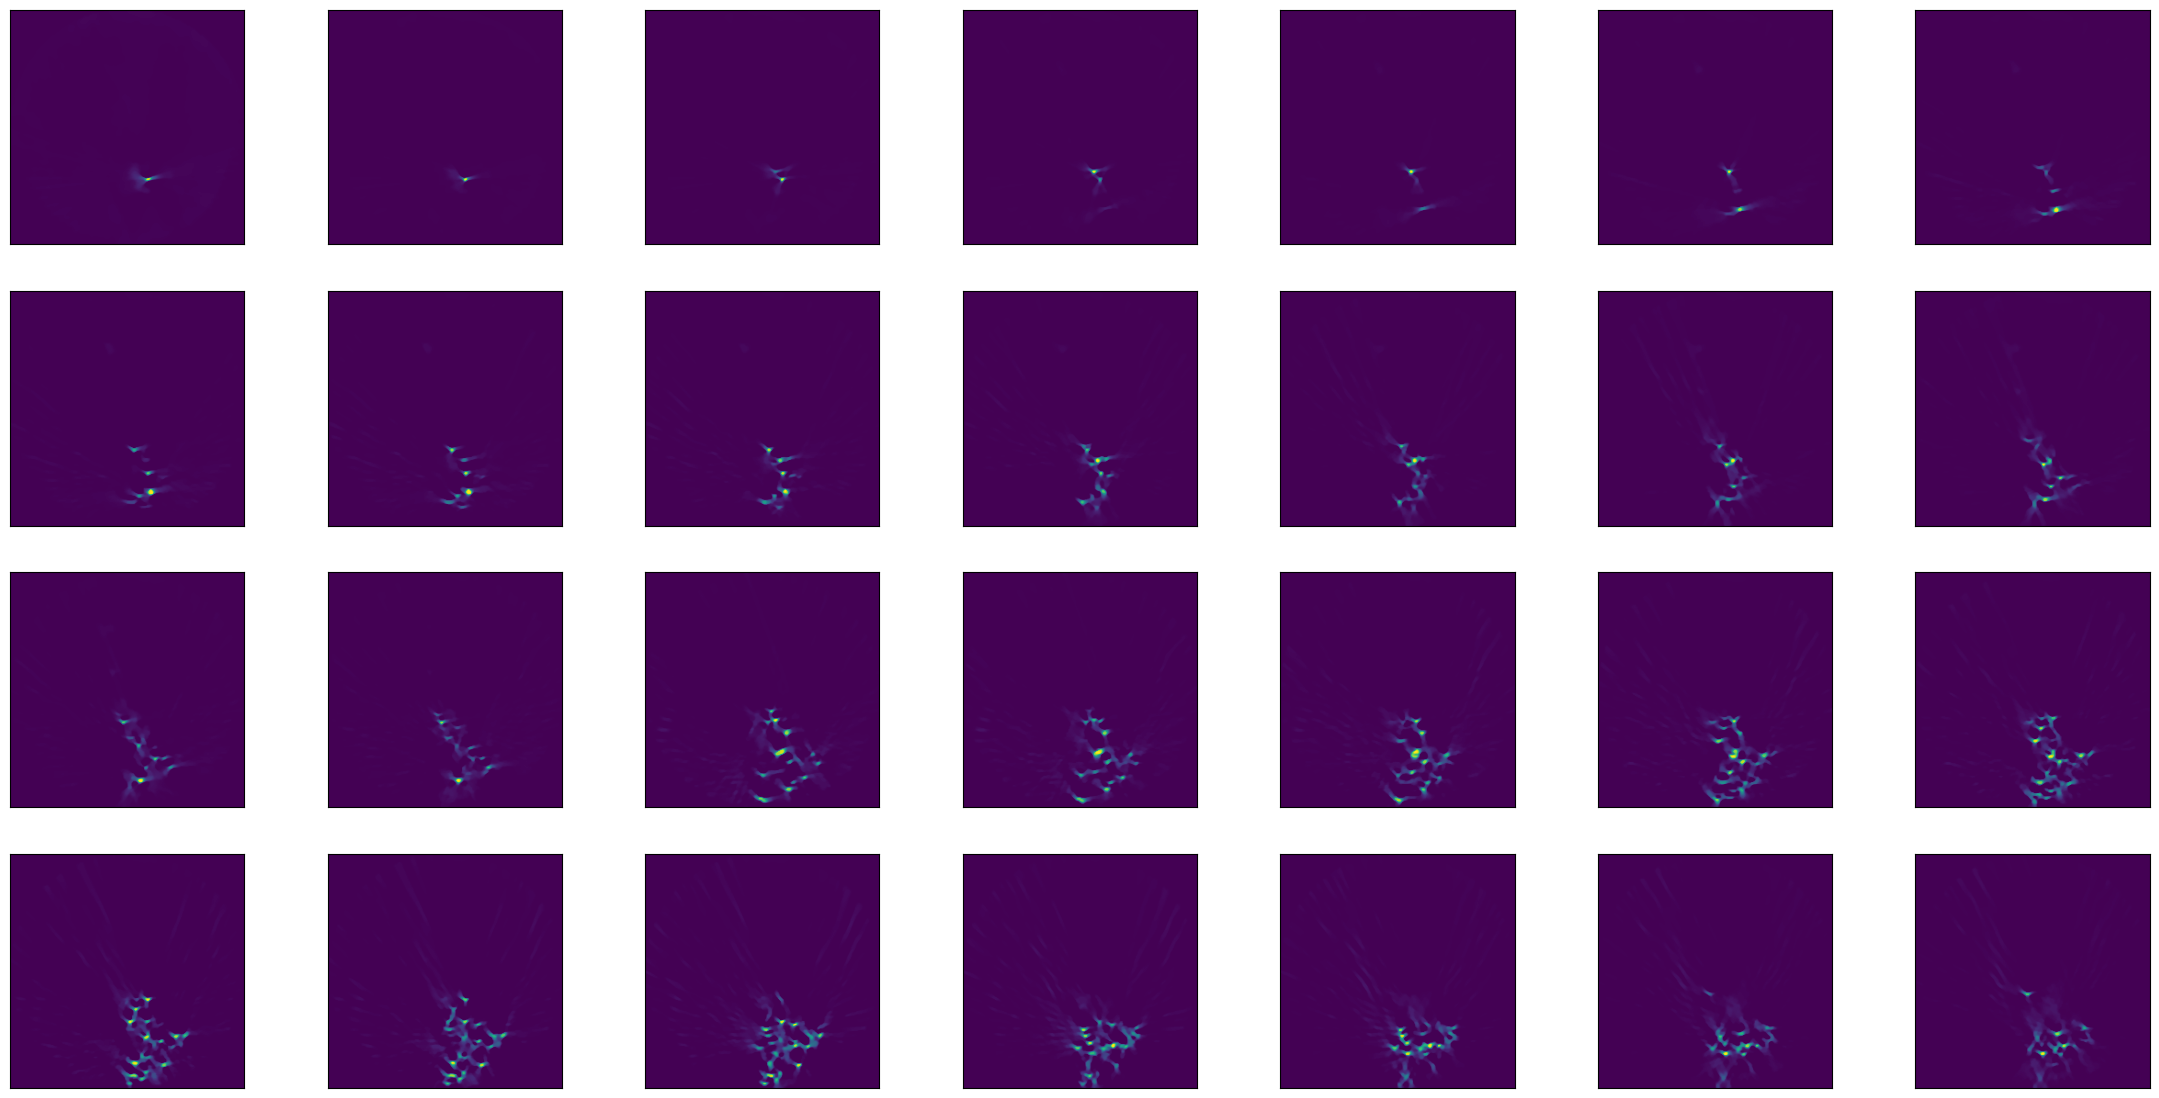

In [26]:
fig, ax = plt.subplots(4, 7, figsize=(28, 14))
for i in range(4):
    for j in range(7):
        ax[i,j].set_xticks([]); ax[i,j].set_yticks([])
        ax[i,j].imshow(rec[7*i+j])